In [1]:

import pandas as pd

from utils.io import yaml_to_dict,dict_to_yaml

from cleanco import basename

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

# from projects.lobbying.postproc import terms_present
import matplotlib.colors as mc

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

In [363]:
def invert_sector_dict(sectors_path) -> Dict[str, str]:
    """reads in the sector assignment yaml to dict; inverts dict s.t. each company is a key"""
    sector_assignments = yaml_to_dict(sectors_path)

    all_companies = []
    for _, value in sector_assignments.items():
        all_companies = all_companies + value
    # print(all_companies)

    company_sector_dict = {}
    for k, vv in sector_assignments.items():
        for v in vv:
            company_sector_dict = company_sector_dict | {v: k}

    return company_sector_dict

In [383]:
df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/oct9_postprocessed_ccs_lda_filings.csv"
)

df[
    [
        "ccs_company",
        "ccs_description",
        "ccs_bills",
        "ccs_bills_number_only",
        "bills_with_ccs_terms",
        "definitely_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "h2_mention_core_ff",
        "potentially_ccs",
    ]
].sum()

ccs_company               1046
ccs_description           9234
ccs_bills                 3254
ccs_bills_number_only     3838
bills_with_ccs_terms      3584
definitely_ccs           13030
very_likely_ccs          13754
likely_ccs               14225
h2_mention_core_ff        1955
potentially_ccs          26041
dtype: int64

In [384]:
companies_df = (
    df[
        [
            "client_name_on_filing_document",
            "client_id",
            "organization",
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "definitely_ccs",
        ]
    ]
    .groupby(["client_name_on_filing_document", "client_id"])
    .agg(
        {
            "organization": "first",
            "sector": "first",
            "lumped_sector": "first",
            "very_lumped_sector": "first",
            "definitely_ccs": "max",
        }
    )
)
companies_df.reset_index(inplace=True)
companies_df.sort_values(
    by=["organization", "client_name_on_filing_document", "client_id"], ascending=True
).to_clipboard()

In [385]:
# for plotting and analysis, subset to only the 'definitely ccs' lobbying activities
df = df.loc[df.definitely_ccs == 1]

tot_dollars = df.lobbying_activity_usd.sum()

tot_contacts = df.n_entities_lobbied.sum()

tot_dollars_since_2019 = df.loc[df.filing_year > 2018].lobbying_activity_usd.sum()

tot_contacts_since_2019 = df.loc[df.filing_year > 2018].n_entities_lobbied.sum()

# compute percentages of total dollars and entity contacts for all years
df["pct_of_lobbying_dollars_definitely_ccs"] = [
    100 * x / tot_dollars for x in df.lobbying_activity_usd
]

df["pct_of_entity_contacts_definitely_ccs"] = [
    100 * x / tot_contacts for x in df.n_entities_lobbied
]

# compute percentages of total dollars and entity contacts since 2019
df["pct_of_lobbying_dollars_definitely_ccs_since_2019"] = [
    100 * x / tot_dollars_since_2019 if y > 2018 else 0
    for x, y in zip(df.lobbying_activity_usd, df.filing_year)
]

df["pct_of_entity_contacts_definitely_ccs_since_2019"] = [
    100 * x / tot_contacts_since_2019 if y > 2018 else 0
    for x, y in zip(df.n_entities_lobbied, df.filing_year)
]

In [386]:
print("dollars spent")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].lobbying_activity_usd.sum()
print(f"From Jan 1 2019 through June 30 2024 ${since_2019:.0f}")
print(f"${df.loc[(df.definitely_ccs == 1)].lobbying_activity_usd.sum():.0f}")
print("contacts made")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].n_entities_lobbied.sum()
print(f"From Jan 1 2019 through June 30 2024: {since_2019}")
print(df.loc[(df.definitely_ccs == 1)].n_entities_lobbied.sum())

dollars spent
From Jan 1 2019 through June 30 2024 $427472371
$755530631
contacts made
From Jan 1 2019 through June 30 2024: 33636
57066


In [387]:
print("CCS lobbying contacts per work day since start of 2019:")
33636 / (50 * 5 * 5.5)

CCS lobbying contacts per work day since start of 2019:


24.462545454545456

In [389]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars_definitely_ccs",
            "pct_of_entity_contacts_definitely_ccs",
        ]
    ]
    .loc[df["definitely_ccs"] == 1]
    .groupby(["sector"])
    .agg(
        {
            "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars_definitely_ccs": sum,
            "pct_of_entity_contacts_definitely_ccs": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df.to_clipboard()

In [390]:
core_ff_sectors = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/config_ccs_lda.yml"
)["core_ff_sectors"]
df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()

77.69730054474694

In [391]:
77.697 / 3.1

25.063548387096773

In [392]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars_definitely_ccs",
            "pct_of_entity_contacts_definitely_ccs",
        ]
    ]
    .loc[df["definitely_ccs"] == 1]
    .groupby(["lumped_sector"])
    .agg(
        {
            # "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars_definitely_ccs": sum,
            "pct_of_entity_contacts_definitely_ccs": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df  # .to_clipboard()

,very_lumped_sector,lobbying_activity_usd,n_entities_lobbied,pct_of_lobbying_dollars_definitely_ccs,pct_of_entity_contacts_definitely_ccs
lumped_sector,,,,,
FOSSIL FUEL,FOSSIL-FUEL,2.564852e+08,14749,33.947692,25.845512
INVESTOR-OWNED-POWER-SECTOR,POWER-UTILITIES,2.326190e+08,9509,30.788822,16.663162
CHEMICALS,CHEMICALS,5.081514e+07,3445,6.725755,6.036870
TRANSPORT,TRANSPORT,3.665724e+07,2855,4.851854,5.002979
NON-FF-INDUSTRY,NON-FF-INDUSTRY,2.375453e+07,3159,3.144085,5.535696
BUSINESS-ADVOCACY,BUSINESS-ADVOCACY,2.253399e+07,1526,2.982539,2.674097
ENGINEERING-TECH,ENGINEERING-TECH,2.232233e+07,3249,2.954524,5.693408
BIOFUEL-SYNFUEL,BIOFUEL-SYNFUEL,2.034667e+07,3841,2.693030,6.730803
MUNICIPAL-UTILITIES,POWER-UTILITIES,1.702399e+07,1470,2.253250,2.575965


In [393]:
for sector in [
    "higher education",
    "think tanks and issue advocacy",
    "environmental",
    "finance",
    "independent research organization",
    "business advocacy",
]:
    ccs_sector_df = (
        df[["organization", "lobbying_activity_usd"]]
        .loc[df.sector == sector]
        .groupby(["organization"])
        .sum()
        .sort_values(by=["lobbying_activity_usd"], ascending=False)
    )
    display(ccs_sector_df)

,lobbying_activity_usd
organization,
UNIVERSITY OF PITTSBURGH,588869.047619
UNIVERSITY OF ILLINOIS,169549.494949
YALE UNIVERSITY,153142.857143
UNIVERSITY OF KENTUCKY,110076.596667
OHIO UNIVERSITY,91930.069930
UNIVERSITY OF TEXAS,73750.000000
UNIVERSITY OF MICHIGAN,72018.000920
CALIFORNIA INSTITUTE OF TECHNOLOGY,72000.000000
ARIZONA STATE UNIVERSITY,64072.916667


,lobbying_activity_usd
organization,
BIPARTISAN POLICY CENTER,1.189484e+06
NATIONAL RIGHT TO WORK COMMITTEE,4.520000e+05
COALITION FOR ENERGY EFFICIENT JOBS INVESTMENT,3.000000e+05
CLEARPATH ACTION FOR CONSERVATIVE CLEAN ENERGY,2.000000e+05
ELECTRIFY AMERICA,1.050000e+05
CENTER FOR AMERICAN PROGRESS,6.285714e+04
AMERICANS FOR TAX REFORM,6.157432e+04
CENTER FOR TRANSPORTATION AND ENVIRONMENT,6.000000e+04
SECURING AMERICAS FUTURE ENERGY,3.716667e+04


,lobbying_activity_usd
organization,
CLEAN AIR TASK FORCE,2.271968e+06
NATURE CONSERVANCY,1.921032e+06
CITIZENS FOR RESPONSIBLE ENERGY SOLUTIONS,1.429333e+06
ENVIRONMENTAL DEFENSE FUND,5.740713e+05
EARTHJUSTICE,5.575148e+05
WILDERNESS SOCIETY,4.312894e+05
LINDEN TRUST FOR CONSERVATION,3.700000e+05
SIERRA CLUB,3.609724e+05
SOUTHERN ENVIRONMENTAL LAW CENTER,3.533571e+05


,lobbying_activity_usd
organization,
ZURICH,2.082202e+06
BREAKTHROUGH ENERGY,2.075286e+06
NATIONAL VENTURE CAPITAL ASSOCIATION,1.500079e+06
NATIONAL ASSOCIATION OF FEDERALLYINSURED CREDIT UNIONS,1.020000e+06
AMERICAS CREDIT UNIONS,9.443407e+05
LEUCADIA NATIONAL,2.200000e+05
INVESTMENT INSTITUTE,2.145813e+05
ARTHUR J GALLAGHER,1.450000e+05
BANK OF AMERICA,9.714286e+04


,lobbying_activity_usd
organization,
GREAT PLAINS INSTITUTE,326333.333333
WORLD RESOURCES INSTITUTE,180000.000000
WOODWELL CLIMATE RESEARCH CENTER,10000.000000
RTI INTERNATIONAL,4000.000000


,lobbying_activity_usd
organization,
US CHAMBER OF COMMERCE,1.806379e+07
NATIONAL ASSOCIATION OF MANUFACTURERS,3.809658e+06
BUSINESS ROUNDTABLE,4.175000e+05
GREATER PITTSBURGH CHAMBER OF COMMERCE,1.363810e+05
WESTERN BUSINESS ROUNDTABLE,1.066667e+05
BUSINESS COUNCIL OF ALABAMA,0.000000e+00


In [338]:
import numpy as np
from statistics import mode

df[
    [
        "filing_year",
        "organization",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "filing_year",
    ]
].loc[df.definitely_ccs == 1].groupby("organization").sum()

,filing_year,lobbying_activity_usd,n_entities_lobbied,filing_year
client_rename,,,,
ABB,6069,4.969697e+04,12,6069
ACCELERGY,14066,2.294444e+05,28,14066
ACLIMA,24264,2.580000e+05,58,24264
ADVANCED BIOFUELS ASSOCIATION,12126,1.100000e+05,17,12126
ADVANTEK WASTE MANAGEMENT,2021,2.500000e+04,3,2021
...,...,...,...,...
YALE UNIVERSITY,12123,1.531429e+05,12,12123
YUM BRANDS,6063,9.000000e+04,7,6063
ZERO CARBON HYDROGEN COALITION,14151,4.400000e+05,14,14151


In [394]:
# Table of sector totals, including since 2019

since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["sector"])
    .agg(
        {
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "General sector",
    "total_ccs_lobbying_usd_2019_to_mid_2024",
    "total_ccs_lobbying_contacts_2019_to_mid_2024",
]
total_df = (
    df[
        [
            "sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["sector"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_mid2024",
    "total_ccs_lobbying_contacts_2005_to_mid2024",
]

sector_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
sector_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_mid_2024", ascending=False, inplace=True
)
sector_summary_df = sector_summary_df[
    [
        "General sector",
        "total_ccs_lobbying_usd_2019_to_mid_2024",
        "total_ccs_lobbying_usd_2005_to_mid2024",
        "total_ccs_lobbying_contacts_2019_to_mid_2024",
        "total_ccs_lobbying_contacts_2005_to_mid2024",
    ]
].to_clipboard()

In [395]:
# Table of organization totals, including since 2019

since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .agg(
        {
            "sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "Detailed sector",
    "General sector",
    "total_ccs_lobbying_usd_2019_to_mid_2024",
    "total_ccs_lobbying_contacts_2019_to_mid_2024",
]
total_df = (
    df[
        [
            "filing_year",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["organization"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_mid2024",
    "total_ccs_lobbying_contacts_2005_to_mid2024",
]

company_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
company_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_mid_2024", ascending=False, inplace=True
)
company_summary_df = company_summary_df[
    [
        "General sector",
        "Detailed sector",
        "total_ccs_lobbying_usd_2019_to_mid_2024",
        "total_ccs_lobbying_usd_2005_to_mid2024",
        "total_ccs_lobbying_contacts_2019_to_mid_2024",
        "total_ccs_lobbying_contacts_2005_to_mid2024",
    ]
].to_clipboard()

In [396]:
# get all-organization totals for past 20 years and past 5
total_series = (
    df[
        [
            "filing_year",
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(18)
    .sum()
)
since_2019_series = (
    df[
        [
            "filing_year",
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs_since_2019",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(22)
    .sum()
)
print(" *** 2005-2024 ***")
print(total_series)
print("")
print(" *** 2019-2024 ***")
print(since_2019_series)

 *** 2005-2024 ***
filing_year                               4.687519e+06
lobbying_activity_usd                     3.799065e+08
pct_of_lobbying_dollars_definitely_ccs    5.028340e+01
n_entities_lobbied                        1.406400e+04
energy, dept of                           1.073000e+03
environmental protection agency (epa)     9.690000e+02
legistlative_entities_lobbied             4.882000e+03
executive_entities_lobbied                9.182000e+03
dtype: float64

 *** 2019-2024 ***
filing_year                                          2.820117e+06
lobbying_activity_usd                                2.129937e+08
pct_of_lobbying_dollars_definitely_ccs_since_2019    4.982630e+01
n_entities_lobbied                                   7.626000e+03
energy, dept of                                      5.950000e+02
environmental protection agency (epa)                4.900000e+02
legistlative_entities_lobbied                        2.975000e+03
executive_entities_lobbied                  

Text(0.5, 1.0, 'Dollars spent lobbying the US Federal Government regarding CCS')

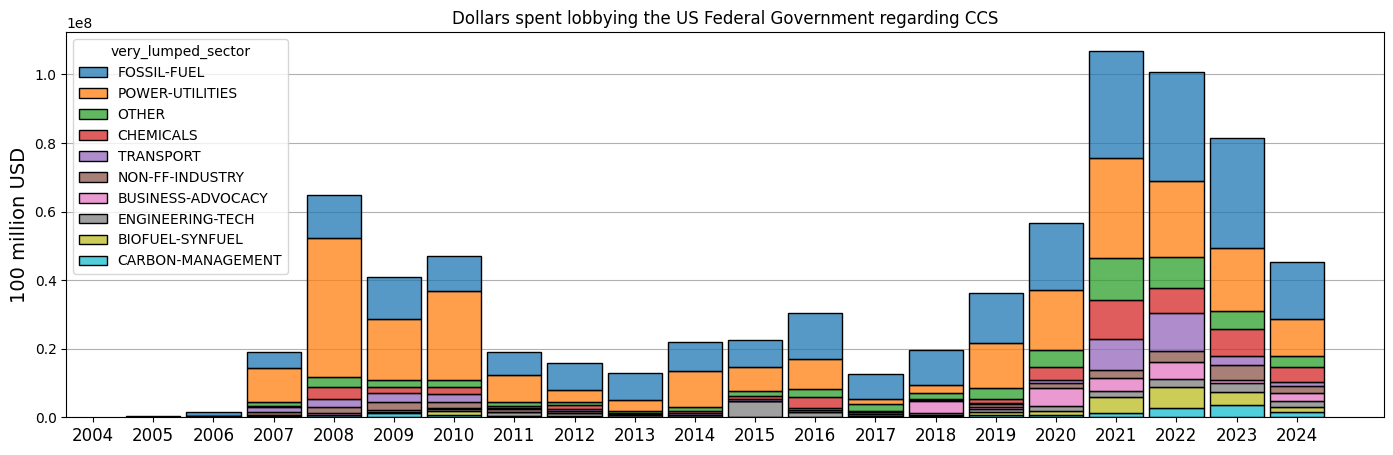

In [397]:
# for histogram hue ordering:
sector_for_group = "very_lumped_sector"
very_lumped_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue=sector_for_group,
    hue_order=very_lumped_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette="tab10",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")
ax.set_title("Dollars spent lobbying the US Federal Government regarding CCS")

Text(0.5, 0, '')

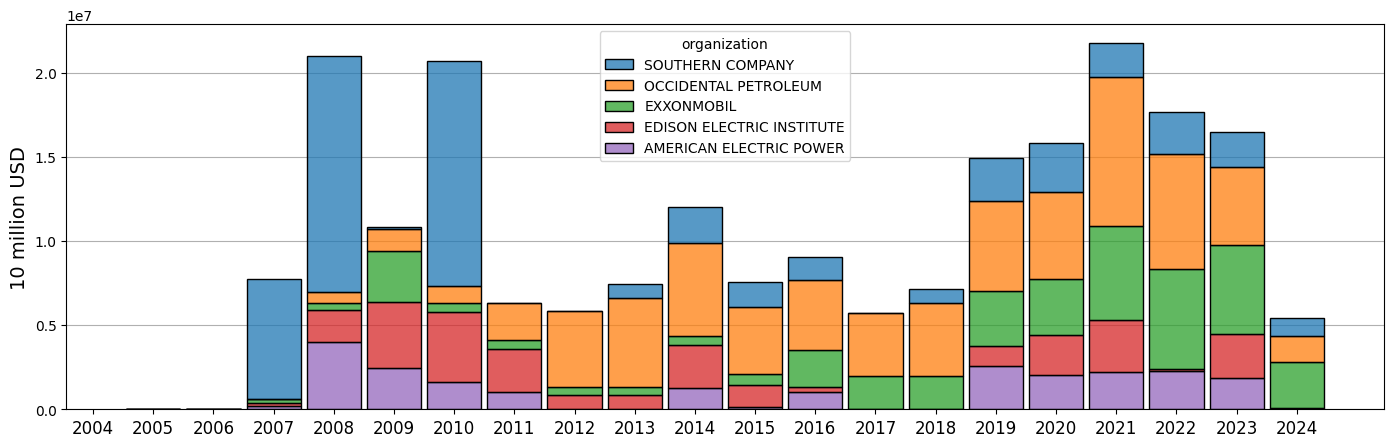

In [382]:
top_10 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
    "US CHAMBER OF COMMERCE",
    "SHELL",
    "DUKE",
    "BP AMERICA",
    "CHEVRON",
]
top_3 = ["EXXONMOBIL", "OCCIDENTAL PETROLEUM", "SOUTHERN COMPANY"]
top_5 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
]
top_df = (
    df[["lobbying_activity_usd", "n_entities_lobbied", "organization", "filing_year"]]
    .loc[(df.very_likely_ccs == 1) & (df.organization.isin(top_5))]
    .groupby(["filing_year", "organization"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)

years = list(range(2004, 2025))

fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=top_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="organization",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("10 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")